# FUEGO

FUEGO is a feature-pivot method that uses a sliding time window mechanism to detect when something happens in real-time.
Normally, Topic Detection and Tracking (TDT) approaches try to identify when _something_ happens.
FUEGO is slightly different: it receives as part of its inputs a list of streams.
Each stream represents a type of development, or closely-related develpoments, and identifies when any of these developments occur.

The idea behind FUEGO is that we know in advance what kind of developments can happen, so we can keep an eye out for them.
This has several advantages, such as:

- We can deal with spam more easily.
- Since the streams are so focused, we can do away with clustering, allowing for a finer granularity.

This notebook goes through FUEGO's steps:

1. Tweet filtering
2. Deciding whether a stream might have developments
3. Scoring words (also known as nutrition)
4. Detecting whether any words are breaking

Set up the notebook with details about the dataset.
This notebook focuses on the match between Southampton FC and Arsenal FC, which the latter won 2-0.
During the match, there was also one red card and two bookings.

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patheffects as pe
import json
import math
import os
import statistics
import sys

sys.path.append(os.path.expanduser("~/GitHub/EvenTDT"))
sys.path.append(os.path.expanduser("~/GitHub/multiplex-plot"))
sys.path = list(set(sys.path))

from eventdt.objects.exportable import Exportable
from eventdt.queues import Queue
from eventdt.queues.consumers.algorithms import FUEGOConsumer
from eventdt import twitter
from eventdt.twitter import corpus

from multiplex import drawable

understanding = os.path.expanduser('~/DATA/c6-tdt/data/#SOUARS/.cache/understanding.json')
file = os.path.expanduser('~/DATA/c6-tdt/data/#SOUARS/event.json')
split, track = [ 'goal', 'score', 'conced', 'equalis', 'offsid', 'assist' ], 'willock'

Set up the visualization style to use in this notebook.

In [2]:
plt.style.use(os.path.join(os.getcwd(), '../modern-custom.style'))
style = { 'linewidth': 3, 'with_legend': True, 'zorder': 1,
          'path_effects': [ pe.Stroke(linewidth=6, foreground='C4'), pe.Normal() ] }
marker_style = { 'marker': 'o', 'markersize': 9 }
scatter_style = { 's': marker_style['markersize'] ** 2, 'zorder': 2 }
annotation_marker_style = dict(marker_style)
annotation_marker_style.update({ 'markersize': 13, 'markeredgewidth': 3, 'markeredgecolor': 'C4' }) # 18-4=14 (markersize)
line_style = { 'alpha': 0.3, 'linestyle': '--', 'linewidth': 1 }
annotation_style = { 'align': 'right', 'fontsize': 'smaller', 
                     'va': 'center', 'alpha': 0.8, 'facecolor': '#ffffff99' }

faded_style = dict(style)
faded_style.update({ 'color': 'C5' })
highlight_style = dict(style)
highlight_style.update({ 'color': 'C0' })

FUEGO's process is split into two:

1. The understanding period precedes the event. During this time, FUEGO captures some information about the event. It uses this data to construct a TF-ICF term-weighting scheme, which it later uses to weight terms.
2. The actual processing period, or the event period, is when the action happens. FUEGO's job at this point is to identify when something new and noteworthy happens.

## Understanding Period

FUEGO's understanding period is very simple.
Assuming that the dataset has already been collected, FUEGO constructs a TF-ICF term-weighting scheme from this corpus.
The point of this term-weighting scheme is that the algorithm will be able to understand, later, how often we can expect to observe different words.

For example, if the word _Arsenal_ is very common before _and_ during the event, then it probably describes something very general about an event.
On the contrary, if the word _goal_ is rarely mentioned before the event, but suddenly people start talking about it during the event, then it's like that the word represents a development.

In [3]:
with open(understanding) as f:
    data = json.loads(f.readline())
    scheme = Exportable.decode(data)['scheme']
consumer = FUEGOConsumer(Queue(), scheme=scheme)

14:43:41: INFO: Window size:      60
14:43:41: INFO: Tracking:         90
14:43:41: INFO: Burst:            [0.5, 0.2]
14:43:41: INFO: Minimum volume:   15
14:43:41: INFO: Threshold:        DynamicThreshold.MEAN
14:43:41: INFO: Filtering:        FilteringLevel.STRICT
14:43:41: INFO: Reporting:        ReportingLevel.ALL
14:43:41: INFO: Storage:          StorageLevel.TWEET
14:43:41: INFO: Scheme:           <class 'nlp.weighting.tfidf.TFIDF'> (15135 documents)


## Event Period

### 1. Filtering

FUEGO filters tweets aggressively. It uses rules from FIRE and ELD. FIRE's rules are:

1. The tweet has to be in English,

2. The tweet must contain no more than 2 hashtags,

3. The tweet's author must have favorited at least one tweet, and

4. The tweet's author must have at least one follower for every thousand tweets they've published.

ELD's rule is:

5. The biography of the tweet's author cannot be empty because that is indicative of bots.

6. The tweet may have no more than one URL. FUEGO is harsher, and rejects all tweets with URLs in them.

We'll be doing a lot of counting in this notebook.
Before going through FUEGO's process during the event period, we define a function that we'll use to count the number of tweets.

In [4]:
def volume(bin, track=None, filtered=False, *args, **kwargs):
    """
    Count the number of tweets in the given bin.

    :param bin: A bin containing a list of tweets to count.
    :type bin: list of dict
    :param track: The keyword to track.
                  These are not used in this function.
    :type track: None or str
    :param filtered: A boolean indicating whether to filter tweets using FUEGO's rules.
    :type filtered: bool

    :return: The number of tweets in the bin.
    :rtype: int
    """
    
    return len(bin) if not filtered else len(consumer._filter_tweets(bin))

with open(file) as f:
    total = corpus.aggregate(f, agg=volume, bin_size=60)
    f.seek(0)
    filtered = corpus.aggregate(f, agg=volume, bin_size=60, filtered=True)

The original event is shown below, with annotations of the most important moments during the match.
Other important moments in TDT, not shown here, include the start and end of each half, two yellow cards and a red card.

Note that when something big happens, there's a spike in volume.
Those spikes are what feature-pivot approaches attempt to extract.

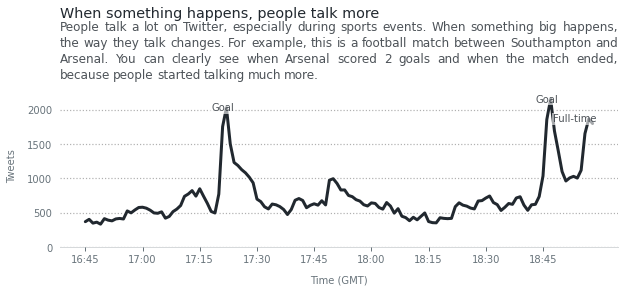

In [5]:
"""
Prepare the data.
"""
term = '*'
timestamps = sorted(total.keys())[1:-1]
term_volume = [ total.get(timestamp, { }).get(term) for timestamp in timestamps ]
annotations = {
    (timestamps.index(timestamps[-2]) + 2, term_volume[timestamps.index(timestamps[-2])]): 'Full-time',
    (timestamps.index(timestamps[-12]) + 2, term_volume[timestamps.index(timestamps[-12])]): 'Goal',
    (timestamps.index(timestamps[37]) + 2, term_volume[timestamps.index(timestamps[37])]): 'Goal',
}

"""
Draw the visualization.
"""
plt.style.use(os.path.join(os.getcwd(), '..', "modern-custom.style"))
plt.style.reload_library()
figure = plt.figure(figsize=(10,3))
viz = drawable.Drawable(figure)
viz.set_xlabel('Time (GMT)')
viz.set_ylabel('Tweets')
viz.draw_time_series(range(len(term_volume)), term_volume, **style)

"""
Annotate the visualization.
"""
for (x, y), annotation in annotations.items():
    viz.annotate(annotation, (x - 1, x), y, **annotation_style)

"""
Finalize the visualization.
"""
viz.set_title('When something happens, people talk more', loc='left')
viz.set_caption("""People talk a lot on Twitter, especially during sports events.
                   When something big happens, the way they talk changes.
                   For example, this is a football match between Southampton and Arsenal.
                   You can clearly see when Arsenal scored 2 goals and when the match ended, because people started talking much more.""",
                align='justify')
xticks = [ i for i, timestamp in enumerate(timestamps) if not timestamp % (60 * 15) ]
viz.set_xticks(xticks)
viz.set_xticklabels([ datetime.utcfromtimestamp(timestamps[x]).strftime('%H:%M') for x in xticks ])
viz.set_ylim(0, math.ceil(max(term_volume) * 1.1))
viz.set_yticks(list(range(0, math.ceil(max(term_volume)), 500)))
viz.set_axisbelow(True)
viz.show()

Although FUEGO adopts a rather aggressive filtering strategy, even after removing tweets, the most important developments are still distinguished.
The next visualization shows how many tweets remain after FUEGO filters out tweets.

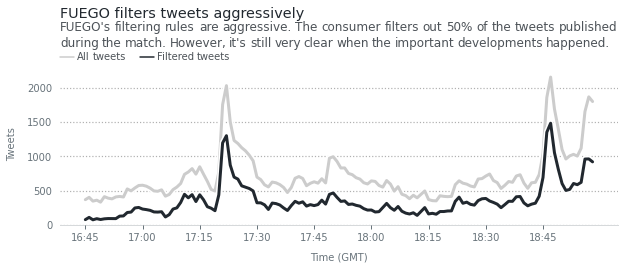

In [6]:
"""
Prepare the data.
"""
term = '*'
timestamps = sorted(total.keys())[1:-1]
term_volume = [ total.get(timestamp, { }).get(term) for timestamp in timestamps ]
filtered_volume = [ filtered.get(timestamp, { }).get(term) for timestamp in timestamps ]
annotations = {
    (timestamps.index(timestamps[-2]), filtered_volume[timestamps.index(timestamps[-2])]): 'End',
    (timestamps.index(timestamps[-12]), filtered_volume[timestamps.index(timestamps[-12])]): 'Goal',
    (timestamps.index(timestamps[37]), filtered_volume[timestamps.index(timestamps[37])]): 'Goal',
}

"""
Draw the visualization.
"""
plt.style.use(os.path.join(os.getcwd(), '..', "modern-custom.style"))
plt.style.reload_library()
figure = plt.figure(figsize=(10,3))
viz = drawable.Drawable(figure)
viz.set_xlabel('Time (GMT)')
viz.set_ylabel('Tweets')
viz.draw_time_series(range(len(term_volume)), term_volume, f"All tweets", **faded_style)
viz.draw_time_series(range(len(term_volume)), filtered_volume, f"Filtered tweets", **style)

"""
Finalize the visualization.
"""
viz.set_title('FUEGO filters tweets aggressively', loc='left')
viz.set_caption(f"""FUEGO's filtering rules are aggressive.
                    The consumer filters out { round(100 - sum(filtered_volume)/sum(term_volume) * 100) }% of the tweets published during the match.
                    However, it's still very clear when the important developments happened.""",
                align='justify')
xticks = [ i for i, timestamp in enumerate(timestamps) if not timestamp % (60 * 15) ]
viz.set_xticks(xticks)
viz.set_xticklabels([ datetime.utcfromtimestamp(timestamps[x]).strftime('%H:%M') for x in xticks ])
viz.set_ylim(0, math.ceil(max(term_volume) * 1.1))
viz.set_yticks(list(range(0, math.ceil(max(term_volume)), 500)))
viz.set_axisbelow(True)
viz.show()

### 2. Streaming

These peaks are important because they tell us what happened, but the peaks in the overall volume only describe the very important developments.
Therefore FUEGO splits the overall volume into multiple streams.

Streams may accept tweets that contain any number of words.
Furthermore, FUEGO can send one tweet to multiple streams.
This notebook focuses only on one stream: the tweets that mention a group of words that relate to fouls.

First, we load the tweets that mention any of the words _card_, _yellow_, _book_ and _foul_ in the dataset.

In [7]:
documents = [ ]
with open(file) as f:
    for line in f:
        tweet = json.loads(line)
        if consumer._validate_tweet(tweet):
            document = consumer._to_documents([ tweet ])[0]
            
            # save this document as relevant if it contains the term
            if any( document.dimensions[word] for word in split ):
                documents.append(document)

Then, we create the FUEGO consumer, which consumes tweets using FUEGO's process.
We send the relevant tweets that mention the word _yellow_ to it.

In [8]:
consumer = FUEGOConsumer(Queue(), scheme, damping=0)
consumer._update_volume(documents)
volume = consumer.volume.all()

# so far, the documents are split per second, so we split them into minutes.
stream = dict.fromkeys(total.keys(), 0)
for timestamp, tweets in volume.items():
    stream[timestamp - timestamp % 60] += tweets

14:44:28: INFO: Window size:      60
14:44:28: INFO: Tracking:         90
14:44:28: INFO: Burst:            [0.5, 0.2]
14:44:28: INFO: Minimum volume:   15
14:44:28: INFO: Threshold:        DynamicThreshold.MEAN
14:44:28: INFO: Filtering:        FilteringLevel.STRICT
14:44:28: INFO: Reporting:        ReportingLevel.ALL
14:44:28: INFO: Storage:          StorageLevel.TWEET
14:44:28: INFO: Scheme:           <class 'nlp.weighting.tfidf.TFIDF'> (15135 documents)


As expected, the volume within the stream is much more subdued.
Looking at the bigger picture, the volume of the stream is also insignificant.
You can't even see any proper peaks!
However, if we isolate the volume of the stream, peaks re-emerge.

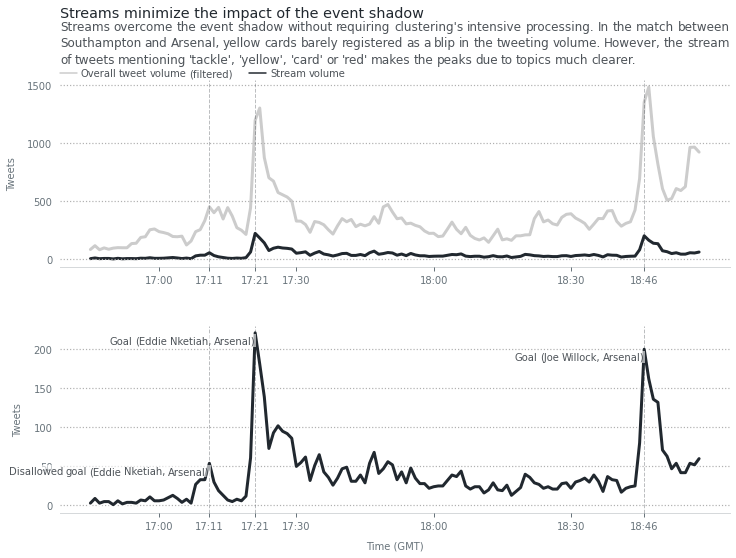

In [9]:
"""
Prepare the data.
"""
term = '*'
timestamps = sorted(filtered.keys())[1:-1]
filtered_volume = [ filtered.get(timestamp, { }).get(term) for timestamp in timestamps ]
stream_volume = [ stream.get(timestamp, { }) for timestamp in timestamps ]
_annotations = {
    (timestamps.index(timestamps[26]), stream_volume[timestamps.index(timestamps[26])] - 10): 
        { 'text': "Disallowed goal (Eddie Nketiah, Arsenal)",
          'style': { 'align': 'right' }},
    (timestamps.index(timestamps[36]), stream_volume[timestamps.index(timestamps[36])] - 10): 
        { 'text': "Goal (Eddie Nketiah, Arsenal)",
          'style': { 'align': 'right' }},
    (timestamps.index(timestamps[121]), stream_volume[timestamps.index(timestamps[121])] - 10): 
        { 'text': "Goal (Joe Willock, Arsenal)",
          'style': { 'align': 'right' }},
}

"""
Set up the visualization.
"""
plt.style.use(os.path.join(os.getcwd(), '..', "modern-custom.style"))
plt.style.reload_library()
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8))

"""
Set up general settings for both plots.
"""
xticks = [ i for i, timestamp in enumerate(timestamps) if not timestamp % (60 * 30) ]
xticks += [ x for (x,y) in _annotations.keys() ]

"""
Draw the isolated stream tweets.
"""
viz = drawable.Drawable(figure, ax2)
viz.set_xlabel('Time (GMT)')
viz.set_ylabel('Tweets')
viz.draw_time_series(range(len(stream_volume)), stream_volume, **style)

viz.set_xticks(xticks)
viz.set_xticklabels([ datetime.utcfromtimestamp(timestamps[x]).strftime('%H:%M') for x in xticks ])
viz.set_yticks(list(range(0, math.ceil(max(stream_volume) * 1.1), 50)))
viz.set_axisbelow(True)

"""
Draw the annotations.
"""
for (x, y), annotation in _annotations.items():
    text, _style = annotation['text'], annotation['style']
    viz.axvline(x, ymin=0, ymax=0.99, **line_style)
    _annotation_style = dict(annotation_style)
    _annotation_style.update(_style)
    _x = (x, x + 45) if _annotation_style.get('align', 'left') == 'left' else (x - 45, x)
    viz.annotate(text, _x, y, **_annotation_style)
viz.redraw()
    
"""
Draw the stream as a subset of all tweets.
"""
viz = drawable.Drawable(figure, ax1)
# viz.set_xlabel('Time (GMT)')
viz.set_ylabel('Tweets')
viz.draw_time_series(range(len(filtered_volume)), filtered_volume, f"Overall tweet volume (filtered)", **faded_style)
viz.draw_time_series(range(len(stream_volume)), stream_volume, f"Stream volume", **style)

viz.set_xticks(xticks)
viz.set_xticklabels([ datetime.utcfromtimestamp(timestamps[x]).strftime('%H:%M') for x in xticks ])
viz.set_yticks(list(range(0, math.ceil(max(filtered_volume) * 1.1), 500)))

"""
Draw the annotations.
"""
for (x, y), annotation in _annotations.items():
    viz.axvline(x, ymin=0, ymax=0.99, **line_style)

"""
Finalize the visualization.
"""
viz.set_title('Streams minimize the impact of the event shadow', loc='left')
viz.set_caption(f"""Streams overcome the event shadow without requiring clustering's intensive processing.
                    In the match between Southampton and Arsenal, yellow cards barely registered as a blip in the tweeting volume.
                    However, the stream of tweets mentioning 'tackle', 'yellow', 'card' or 'red' makes the peaks due to topics much clearer.""",
                align='justify')
viz.show()

In reality, FUEGO does not use the raw volume, but dampens the importance of old retweets.
Normally, old retweets talk about something that happened in the past.
The idea is that these old retweets should not influence what we think is happening now.

\begin{equation}
damp_t =
\begin{cases}
    e^{-\lambda \frac{t_r - t_o}{60}} & \text{if } t \text{ is a retweet}\\
    0                                 & \text{otherwise}
\end{cases}
\end{equation}

Here, $t_r$ is the timestamp when the user retweeted the tweet, and $t_o$ is the timestamp when the original tweet was published.
Note that with this equation, the score never reaches 0, and the maximum score is 1.
That looks something like the following.

In [10]:
def damp(x, l):
    """
    Calculate the damping score of the retweet of a tweet published x seconds earlier.
    
    :param x: The number of seconds that have elapsed since the original tweet was published.
    :type x: int
    :param l: The lambda, or the co-efficient that influences how much damping is applied.
              The higher lambda, the more old retweets are penalized.
    :type l: float
    
    :return: The damping factor to apply to the tweet.
    :rtype: float
    """
    
    return math.exp(- l * x / 60)

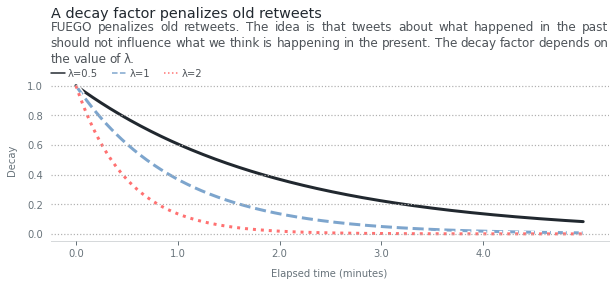

In [11]:
"""
Prepare the data.
"""
x = range(0, 60 * 5)
y05 = [ damp(_x, 0.5) for _x in x]
y1 = [ damp(_x, 1) for _x in x]
y2 = [ damp(_x, 2) for _x in x]

"""
Draw the visualization.
"""
plt.style.use(os.path.join(os.getcwd(), '..', "modern-custom.style"))
plt.style.reload_library()
figure = plt.figure(figsize=(10,3))
viz = drawable.Drawable(figure)
viz.set_xlabel('Elapsed time (minutes)')
viz.set_ylabel('Decay')
viz.draw_time_series(x, y05, f"λ=0.5", **style)
viz.draw_time_series(x, y1, f"λ=1", linestyle='--', **style)
viz.draw_time_series(x, y2, f"λ=2", linestyle=':', **style)

"""
Finalize the visualization.
"""
viz.set_title('A decay factor penalizes old retweets', loc='left')
viz.set_caption(f"""FUEGO penalizes old retweets.
                    The idea is that tweets about what happened in the past should not influence what we think is happening in the present.
                    The decay factor depends on the value of λ.""",
                align='justify')
viz.set_xticks(range(0, max(x) + 1, 60))
viz.set_xticklabels([ _x / 60 for _x in x if not _x % 60 ])
viz.show()

In FUEGO, we use a λ value of 0.5.

In [12]:
consumer = FUEGOConsumer(Queue(), scheme, damping=0.5)
consumer._update_volume(documents)
volume = consumer.volume.all() # so far, the documents are split per minute
damped_stream = dict.fromkeys(total.keys(), 0)
for timestamp, tweets in volume.items():
    damped_stream[timestamp - timestamp % 60] += tweets

14:44:30: INFO: Window size:      60
14:44:30: INFO: Tracking:         90
14:44:30: INFO: Burst:            [0.5, 0.2]
14:44:30: INFO: Minimum volume:   15
14:44:30: INFO: Threshold:        DynamicThreshold.MEAN
14:44:30: INFO: Filtering:        FilteringLevel.STRICT
14:44:30: INFO: Reporting:        ReportingLevel.ALL
14:44:30: INFO: Storage:          StorageLevel.TWEET
14:44:30: INFO: Scheme:           <class 'nlp.weighting.tfidf.TFIDF'> (15135 documents)


The next visualization shows the effects of damping the stream.
In this isolated stream, the effect is not so pronounced because the peaks are already well-defined.
In more voluminous streams, the 'event shadow' that follows developments almost disappears.

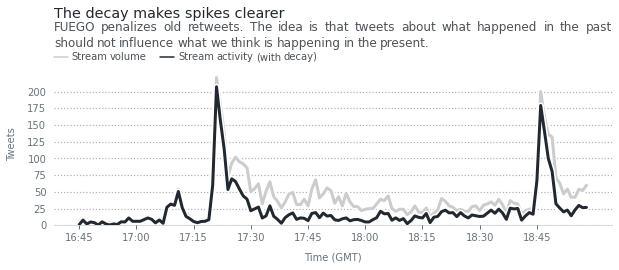

In [13]:
"""
Prepare the data.
"""
term = '*'
timestamps = sorted(stream.keys())[1:-1]
stream_volume = [ stream.get(timestamp, { }) for timestamp in timestamps ]
damped_stream_volume = [ damped_stream.get(timestamp, { }) for timestamp in timestamps ]

"""
Draw the visualization.
"""
plt.style.use(os.path.join(os.getcwd(), '..', "modern-custom.style"))
plt.style.reload_library()
figure = plt.figure(figsize=(10,3))
viz = drawable.Drawable(figure)
viz.set_xlabel('Time (GMT)')
viz.set_ylabel('Tweets')
viz.draw_time_series(range(len(stream_volume)), stream_volume, f"Stream volume", **faded_style)
viz.draw_time_series(range(len(damped_stream_volume)), damped_stream_volume, f"Stream activity (with decay)", **style)

"""
Finalize the visualization.
"""
viz.set_title('The decay makes spikes clearer', loc='left')
viz.set_caption(f"""FUEGO penalizes old retweets.
                    The idea is that tweets about what happened in the past should not influence what we think is happening in the present.""",
                align='justify')
xticks = [ i for i, timestamp in enumerate(timestamps) if not timestamp % (60 * 15) ]
viz.set_xticks(xticks)
viz.set_xticklabels([ datetime.utcfromtimestamp(timestamps[x]).strftime('%H:%M') for x in xticks ])
viz.set_ylim(0, math.ceil(max(stream_volume) * 1.1))
viz.set_yticks(list(range(0, math.ceil(max(stream_volume)), 25)))
viz.set_axisbelow(True)
viz.show()

### 3. Stream activity

FUEGO does not always seek bursty terms.
In the previous visualization, almost all minutes see 5 or fewer tweets.
Whenever the stream is so quiet, it makes little sense to check for bursty terms.
The algorithm only considers the stream to be active if they satisfy two conditions:

1. The stream volume is above a constant amount, which is usually reasonably low.
2. The stream volume is above the median volume observed so far. This is computed by splitting the stream so far into sliding time windows.

The reasoning between these two conditions is that whenever something happens, we can expect to observe a spike.
That spike should reach higher than a set amount (the first condition), and certainly higher than the median so far.

In this example, we set the bar at 5 tweets per minute.
The median changes dynamically and is calculated using sliding time windows.

In [14]:
minimum = 15
medians, means, stdevs, deviations = { }, { }, { }, { }
for timestamp in damped_stream:
    current, historic = consumer._partition(timestamp)
    if len(historic) > 2 and False:
        quantiles = statistics.quantiles(historic.values(), n=100)
        percentile = quantiles[95-1]
        filtered = { timestamp: volume for timestamp, volume in historic.items() if volume > percentile }
        medians[timestamp] = (statistics.median(filtered.values())) if filtered else 0
        means[timestamp] = (statistics.mean(historic.values())) if filtered else 0
        stdevs[timestamp] = statistics.stdev(historic.values()) if len(filtered) >= 2 else 0
    else:
        medians[timestamp] = (statistics.median(historic.values())) if historic else current
        stdevs[timestamp] = statistics.stdev(historic.values()) if historic and len(historic) >= 2 else 0
        means[timestamp] = (statistics.mean(historic.values())) if historic else current
#         print(datetime.utcfromtimestamp(timestamp).strftime('%H:%M'), ':', historic.values(), means[timestamp])
        
        # NOTE: the next snippet considers only the 10 most recent time windows
#         recent = sorted(historic.keys(), reverse=True)[:10]
#         recent = [ historic[t] for t in recent ]
#         means[timestamp] = (statistics.mean(recent)) if historic else current
        
        deviations[timestamp] = (statistics.mean([ abs(v - means[timestamp]) for v in historic.values() ])) if historic else 0

As shown next, these two conditions limit the number of times we have to check for breaking terms.
In addition, it comfortably includes all of the spikes that indicate something happened.

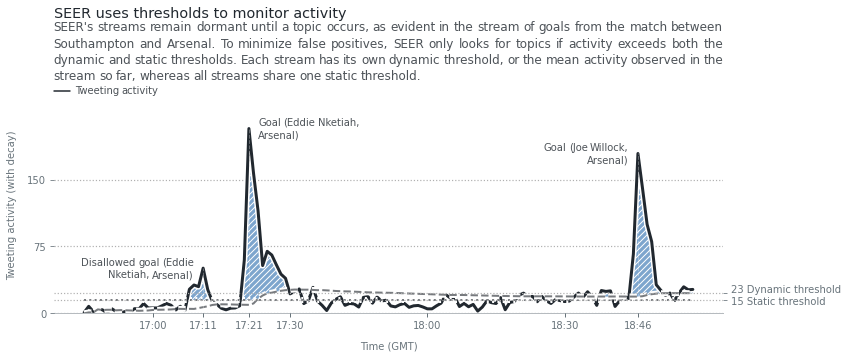

In [15]:
"""
Prepare the data.
"""
timestamps = sorted(stream.keys())[1:-1]
damped_stream_volume = [ damped_stream.get(timestamp, { }) for timestamp in timestamps ]
minimum_volume = [ minimum ] * len(damped_stream_volume)
dynamic_threshold = [ means.get(timestamp) + stdevs.get(timestamp) * 0 for timestamp in timestamps ]
_annotations = {
    (timestamps.index(timestamps[26]), damped_stream_volume[timestamps.index(timestamps[26])]): 
        { 'text': "Disallowed goal (Eddie Nketiah, Arsenal)",
          'style': { 'align': 'right' }},
    (timestamps.index(timestamps[36]), damped_stream_volume[timestamps.index(timestamps[36])]): 
        { 'text': "Goal (Eddie Nketiah, Arsenal)",
          'style': { 'align': 'left' }},
    (timestamps.index(timestamps[121]), damped_stream_volume[timestamps.index(timestamps[121])]): 
        { 'text': "Goal (Joe Willock, Arsenal)",
          'style': { 'align': 'right' }},
}

"""
Draw the visualization.
"""
plt.style.use(os.path.join(os.getcwd(), '..', "modern-custom.style"))
plt.style.reload_library()
figure, ax1 = plt.subplots(figsize=(12,4))
viz = drawable.Drawable(figure, ax1)
viz.set_xlabel('Time (GMT)')
viz.set_ylabel('Tweeting activity (with decay)')
viz.draw_time_series(range(len(damped_stream_volume)), damped_stream_volume, f"Tweeting activity", **style)
_faded_style = dict(faded_style)
_faded_style.update({ 'color': 'C3', 'linewidth': 2 })
viz.draw_time_series(range(len(damped_stream_volume)), minimum_volume, linestyle=':', **_faded_style)
viz.draw_time_series(range(len(damped_stream_volume)), dynamic_threshold, linestyle='--', **_faded_style)

threshold = [ max(s,d) for s, d in zip(minimum_volume, dynamic_threshold) ]
viz.fill_between(range(len(damped_stream_volume)), damped_stream_volume, threshold,
                 where=[ _volume > _threshold for _volume, _threshold in zip(damped_stream_volume, threshold) ],
                 interpolate=True, hatch='////', color='C1', alpha=1, linewidth=0, edgecolor='C4')

"""
Draw the annotations.
"""
_line_style = dict(line_style)
_line_style.update({ 'color': 'C4' })
for (x, y), annotation in _annotations.items():
    text, _style = annotation['text'], annotation['style']
    viz.vlines(x, ymin=0, ymax=y, **_line_style)
    _annotation_style = dict(annotation_style)
    _annotation_style.update(_style)
    _x = (x, x + 30) if _annotation_style.get('align', 'left') == 'left' else (x - 30, x)
    viz.annotate(text, _x, y, pad=2, **_annotation_style)

"""
Finalize the visualization.
"""
viz.set_title('SEER uses thresholds to monitor activity', loc='left')
viz.set_caption(f"""SEER's streams remain dormant until a topic occurs, as evident in the stream of goals from the match between Southampton and Arsenal.
                    To minimize false positives, SEER only looks for topics if activity exceeds both the dynamic and static thresholds.
                    Each stream has its own dynamic threshold, or the mean activity observed in the stream so far, whereas all streams share one static threshold.""",
                align='justify')
xticks = [ i for i, timestamp in enumerate(timestamps) if not timestamp % (60 * 30) ]
xticks += [ x for x, _ in _annotations ]
viz.set_xticks(xticks)
viz.set_xticklabels([ datetime.utcfromtimestamp(timestamps[x]).strftime('%H:%M') for x in xticks ])
viz.set_ylim(0, math.ceil(max(stream_volume) * 1.1))
viz.set_yticks(list(range(0, math.ceil(max(stream_volume)), 75)))
viz.set_axisbelow(True)

# show the threshold on the right
ax2 = ax1.twinx()
ax2.set_ylim(*ax1.get_ylim())
ax2.set_yticks([ minimum_volume[-1], dynamic_threshold[-1] ])
ax2.set_yticklabels([ f"{ minimum_volume[-1] } Static threshold",
                      f"{ round(dynamic_threshold[-1]) } Dynamic threshold\n" ])

viz.savefig('../exports/6.2-thresholds.png', dpi=300, bbox_inches='tight')

### 4. Breaking terms

Whenever these two conditions are met, the algorithm considers that something may have happened.
That does not necessarily mean there was a development, but that it's possible something happened.

To identify whether there really was a development, FUEGO looks for terms that are spiking.
In other words, FUEGO does not just check if there was a spike in volume.
When there is a spike in volume, FUEGO necessitates that there is at least one term that is also spiking.

To verify whether there is a spiking term, FUEGO again uses damping.
The reasoning is identical to before: we don't want old retweets to influence what we think is happening now.
However, differently from the volume calculation, the damping factor is multiplied by the term weight:

\begin{equation}
    n_{j,s} = \sum^{t \in T_s}{ damp_t \cdot w_{j,t} }
\end{equation}

Here, $n_{j,s}$ is the nutrition of word $j$ at timestamp $s$.
It is calculated as a summation over all tweets published at that timestamp: $T_s$.
For each such tweet, the equation considers the weight of the word in that tweet, $w_{j,t}$, and the damping factor of the tweet, $damp_t$.

FUEGO groups the nutrition values into sliding time windows.
Here, we use a sliding time window of one minute.
The consumer is created from scratch so it only contains tweets mentioning the word _yellow_.

In [16]:
consumer = FUEGOConsumer(Queue(), scheme, damping=0.5)
consumer._update_volume(documents)
consumer._update_nutrition(documents)
nutrition = consumer.nutrition.all() # so far, the tweets are split per second
track_stream = dict.fromkeys(total.keys(), 0)
for timestamp, terms in nutrition.items():
    track_stream[timestamp - timestamp % 60] += terms.get(track, 0)

14:44:37: INFO: Window size:      60
14:44:37: INFO: Tracking:         90
14:44:37: INFO: Burst:            [0.5, 0.2]
14:44:37: INFO: Minimum volume:   15
14:44:37: INFO: Threshold:        DynamicThreshold.MEAN
14:44:37: INFO: Filtering:        FilteringLevel.STRICT
14:44:37: INFO: Reporting:        ReportingLevel.ALL
14:44:37: INFO: Storage:          StorageLevel.TWEET
14:44:37: INFO: Scheme:           <class 'nlp.weighting.tfidf.TFIDF'> (15135 documents)


The next visualization shows how the nutrition of Mustafi, who picked up the first yellow card, changes over time.

> You might think that the peak is very low, but that's only partially true.
  The term weights are normalized, so all weights are lower than 1.
  That is why the peak is much lower than the volume.

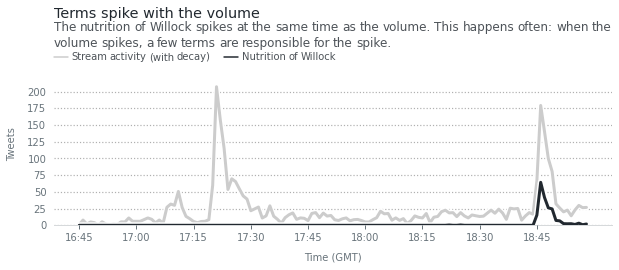

In [17]:
"""
Prepare the data.
"""
timestamps = sorted(stream.keys())[1:-1]
damped_stream_volume = [ damped_stream.get(timestamp, { }) for timestamp in timestamps ]
track_volume = [ track_stream.get(timestamp) for timestamp in timestamps ]

"""
Draw the visualization.
"""
plt.style.use(os.path.join(os.getcwd(), '..', "modern-custom.style"))
plt.style.reload_library()
figure = plt.figure(figsize=(10,3))
viz = drawable.Drawable(figure)
viz.set_xlabel('Time (GMT)')
viz.set_ylabel('Tweets')
viz.draw_time_series(range(len(damped_stream_volume)), damped_stream_volume, f"Stream activity (with decay)", **faded_style)
viz.draw_time_series(range(len(track_volume)), track_volume, f"Nutrition of { track.title() }", **style)

"""
Finalize the visualization.
"""
viz.set_title('Terms spike with the volume', loc='left')
viz.set_caption(f"""The nutrition of { track.title() } spikes at the same time as the volume.
                    This happens often: when the volume spikes, a few terms are responsible for the spike.""",
                align='justify')
xticks = [ i for i, timestamp in enumerate(timestamps) if not timestamp % (60 * 15) ]
viz.set_xticks(xticks)
viz.set_xticklabels([ datetime.utcfromtimestamp(timestamps[x]).strftime('%H:%M') for x in xticks ])
viz.set_ylim(0, math.ceil(max(stream_volume) * 1.1))
viz.set_yticks(list(range(0, math.ceil(max(stream_volume)), 25)))
viz.set_axisbelow(True)
viz.show()

In the above visualization, note two things.
First, the nutrition rises at the same time as the spike in volume.
That happens as the volume itself spiked _because_ people were talking about that development.
Naturally, the same keywords are used and over and over: in this case, Mustafi is mentioned because it was he who picked up the booking.
Second, the nutrition of the term does not rise anywhere else.

That is important, because it means that:

1. When something happens, people talk about it.
2. People do not talk so much about what happened in the past.

Burst is then calculated on the nutrition.
FUEGO uses ELD's algorithm, which means that the burst is always bound between -1 and 1.

In [18]:
burst_stream = {
    timestamp: consumer.tdt.detect(timestamp, min_burst=-1.1).get(track, 0)
               for timestamp in total.keys()
}

Again, notice that burst rises at the same time as nutrition, and does not rise to the same level ever again.

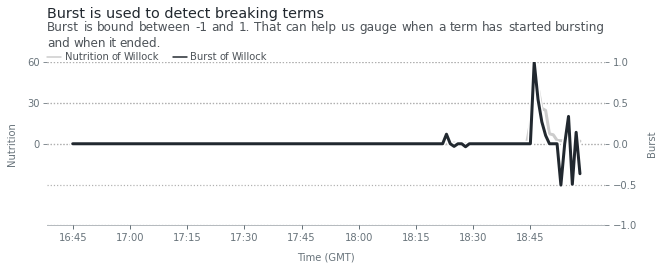

In [19]:
"""
Prepare the data.
"""
timestamps = sorted(stream.keys())[1:-1]
track_volume = [ track_stream.get(timestamp) for timestamp in timestamps ]
burst_volume = [ burst_stream.get(timestamp) if damped_stream.get(timestamp) > minimum else 0
                                             for timestamp in timestamps ]

"""
Draw the visualization.
"""
plt.style.use(os.path.join(os.getcwd(), '..', "modern-custom.style"))
plt.style.reload_library()
figure, ax1 = plt.subplots(figsize=(10,3))
ax2 = ax1.twinx()

"""
Draw the nutrition visualization.
"""
viz = drawable.Drawable(figure, ax1)
viz.set_xlabel('Time (GMT)')
viz.set_ylabel('Nutrition')
viz.draw_time_series(range(len(track_volume)), track_volume, f"Nutrition of { track.title() }", **faded_style)
viz.set_ylim(-60, 60)
viz.set_yticks(list(range(0, 61, 30)))

"""
Draw the burst visualization.
"""
viz.axes = ax2
viz.set_xlabel('Time (GMT)')
viz.set_ylabel('Burst')
viz.draw_time_series(range(len(burst_volume)), burst_volume, f"Burst of { track.title() }", **style)
viz.set_ylim(-1, 1)
viz.set_yticks([ -1 + i / 2 for i in range(0, 5) ])
viz.set_axisbelow(True)

"""
Finalize the visualization.
"""
viz.set_title('Burst is used to detect breaking terms', loc='left')
viz.set_caption(f"""Burst is bound between -1 and 1.
                    That can help us gauge when a term has started bursting and when it ended.""",
                align='justify')
xticks = [ i for i, timestamp in enumerate(timestamps) if not timestamp % (60 * 15) ]
viz.set_xticks(xticks)
viz.set_xticklabels([ datetime.utcfromtimestamp(timestamps[x]).strftime('%H:%M') for x in xticks ])
viz.show()

Next, we focus more specifically on the sharp rise in the number of tweets mentioning Mustafi.

In [20]:
burst = max(burst_volume)
timestamp = timestamps[burst_volume.index(burst)]
start = int(timestamp - 120)
bursts = {
    timestamp: consumer.tdt.detect(timestamp, min_burst=-1.1)
               for timestamp in range(start, start + 60 * 10)
}
burst_stream = {
    timestamp: bursts[timestamp].get(track, 0)
               for timestamp in range(start, start + 60 * 10)
}

In [21]:
printed = 0
for document in documents:
    if track in document.dimensions:
        print(f"{ datetime.utcfromtimestamp(document.attributes['timestamp']).strftime('%H:%M:%S') }: { document }")
        printed += 1
    
    if printed == 10:
        break

18:22:26: Why’s he bringing on Willock when we need a fucking goal
18:25:50: Why are people asking why Willock is coming on? He's going to score a goal.
18:45:30: GOAL. Arsenal. Willock.
18:45:45: Goal. Willock
18:45:46: GOALLLLLLL WILLOCK!!!!!!!
18:45:46: GOAL! WILLOCK MAKES IT 2-0 TO ARSENAL!
18:45:46: GOALLLLLLLLLLLLLLLL WILLOCK
18:45:46: JOE WILLOCK SCORES GOALS!
18:45:47: Willock! Goal
18:45:49: Why are people asking why Willock is coming on? He's going to score a goal.


Bursts usually have a similar pattern split into three phases:

1. A very rapid increase, with burst reaching a value of almost 1 for the most important keyword.
2. Burst stabilizes into a plateau, which lasts for about as long as the time window.
3. Burst decreases, but slower than the original increase.
   When decreasing, it's normal for burst to oscillate at low values about 0.
   After a long period of time, burst reaches 0.

Detected at 18:45:47


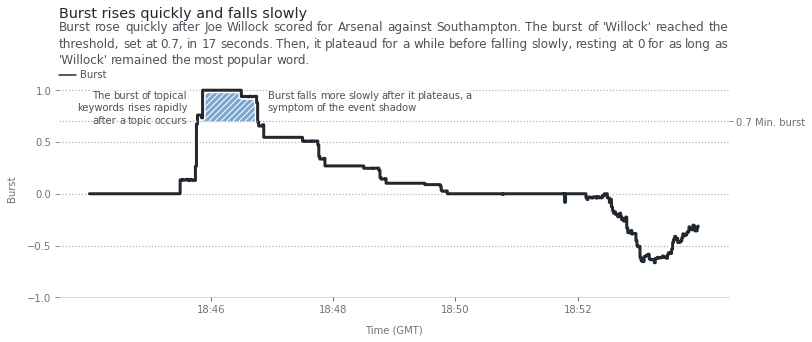

In [22]:
# prepare the data
timestamps = sorted(timestamp for timestamp in burst_stream
                              if not timestamp % 1)[1:-1]
track_volume = [ track_stream.get(timestamp) for timestamp in timestamps ]
burst_volume = [ burst_stream.get(timestamp) for timestamp in timestamps ]
highest = [ timestamp for timestamp in timestamps if burst_stream[timestamp] == 1 ]
threshold = 0.7
non_zero = [ timestamp for timestamp in timestamps if burst_stream[timestamp] > 0 ]
above_threshold = [ timestamp for timestamp in timestamps if burst_stream[timestamp] >= threshold ]
below_threshold = [ timestamps[i] for i in range(1, len(timestamps))
                                  if timestamps[i] > above_threshold[0] and burst_volume[i] < threshold ]
print(f"Detected at { datetime.utcfromtimestamp(above_threshold[0]).strftime('%H:%M:%S') }")

# prepare the annotations
annotations = {
    timestamps.index(min(above_threshold)): {
        'text': 'The burst of topical keywords rises rapidly after a topic occurs',
        'style': { 'align': 'right' }
    },
    timestamps.index(min(below_threshold)): {
        'text': 'Burst falls more slowly after it plateaus, a symptom of the event shadow',
        'style': { 'align': 'left' }
    }
}

# set up the visualization.
plt.style.use(os.path.join(os.getcwd(), '..', "modern-custom.style"))
plt.style.reload_library()
figure, ax1 = plt.subplots(figsize=(12,4))
viz = drawable.Drawable(figure, ax1)

# draw the burst visualization
viz.set_xlabel('Time (GMT)')
viz.set_ylabel('Burst')
viz.draw_time_series(range(len(burst_volume)), burst_volume, f"Burst",
                     drawstyle='steps-post', **style)
viz.fill_between(range(len(burst_volume)), burst_volume, threshold,
                 where=[ _volume > threshold for _volume in burst_volume ],
                 interpolate=True, hatch='////', color='C1', alpha=1, linewidth=0, edgecolor='C4')
viz.set_ylim(-1, 1.1)
viz.set_yticks([ -1 + i / 2 for i in range(0, 5) ])

# describe the burst's phases
_annotation_style = dict(annotation_style)
_annotation_style.update({ 'pad': 0, 'va': 'top', 'zorder': 99 })
for x, annotation in annotations.items():
    text, _style = annotation['text'], annotation['style']
    _astyle = dict(_annotation_style)
    _astyle.update(_style)
    _x = (x - 120, x-10) if _astyle['align'] == 'right' else (x + 10, x + 250)
#     viz.axvline(x, **line_style)
    viz.annotate(text, _x, 1, **_astyle)

# show the threshold on the right
ax2 = ax1.twinx()
ax2.set_ylim(*ax1.get_ylim())
ax2.set_yticks([ threshold ])
ax2.set_yticklabels([ f"{ threshold } Min. burst" ])
ax2.set_frame_on(False)

# finalize the visualization
viz.set_title('Burst rises quickly and falls slowly', loc='left')
viz.set_caption(f"""Burst rose quickly after Joe Willock scored for Arsenal against Southampton.
                    The burst of '{ track.title() }' reached the threshold, set at { threshold }, in { min(above_threshold) - min(non_zero) } seconds.
                    Then, it plateaud for a while before falling slowly, resting at 0 for as long as '{ track.title() }' remained the most popular word.""",
                align='justify')
xticks = [ i for i, timestamp in enumerate(timestamps) if not timestamp % (60 * 2) ]
viz.set_xticks(xticks)
viz.set_xticklabels([ datetime.utcfromtimestamp(timestamps[x]).strftime('%H:%M') for x in xticks ])
viz.set_axisbelow(True)
viz.savefig('../exports/6.2-burst-behaviour.png', dpi=300, bbox_inches='tight')